# 20200902 : LGBM Regressor

*방향*

 2019년 데이터에 취급액 기준 군집을 반영한 후, **전체** 데이터와 **상품군별** 데이터에 대해 MAPE, RMSE 스코어를 측정해 보자. 이전에 비해 성능이 향상되는지 확인한다. 다만, `계절` feature를 기준으로 계층적 샘플링한다.


*결과*
- 전체 상품군에 대해서 LGBM Regessor 적용했을 때 MAPE 스코어 300000(;;) 정도에서 향상되지 않는다.
- 각 상품군에 대해서 적용할 때에는, 역시나 몇몇 상품군 말고는 다 `inf` 값이 나온다.
    - 농수축
    - 의류
    - 이미용
- (의미가 있는지는 모르겠지만) cluster는 변수 중요도가 낮게 나왔고, centroid는 상대적으로 크게 나왔다.

In [26]:
import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
# from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

import os
import matplotlib.pyplot as plt

plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정
%config InlineBackend.figure_format = 'retina'

In [2]:
# 데이터 경로
CLUSTER_DATA = "./data/rawdata_gau3_revClu5.csv"

In [3]:
# 전체 데이터 
data_raw = pd.read_csv(CLUSTER_DATA)
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37298 entries, 0 to 37297
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   방송일시           37298 non-null  object 
 1   노출(분)          37298 non-null  float64
 2   마더코드           37298 non-null  int64  
 3   상품코드           37298 non-null  int64  
 4   상품명            37298 non-null  object 
 5   상품군            37298 non-null  object 
 6   판매단가           37298 non-null  int64  
 7   취급액            37298 non-null  float64
 8   월              37298 non-null  int64  
 9   계절             37298 non-null  object 
 10  일              37298 non-null  int64  
 11  일_일련번호         37298 non-null  int64  
 12  요일             37298 non-null  object 
 13  방송시간대          37298 non-null  int64  
 14  클러스터           37298 non-null  int64  
 15  클러스터_centroid  37298 non-null  float64
dtypes: float64(3), int64(8), object(5)
memory usage: 4.6+ MB


In [4]:
# 데이터 확인
data_raw.tail(2)

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,월,계절,일,일_일련번호,요일,방송시간대,클러스터,클러스터_centroid
37296,2019-12-31 23:40:00,20.0,100448,201384,무이자쿠첸압력밥솥 6인용,주방,158000,2328000.0,12,겨울,31,364,화요일,23,3,-0.019946
37297,2019-12-31 23:40:00,20.0,100448,201391,일시불쿠첸압력밥솥 6인용,주방,148000,10157000.0,12,겨울,31,364,화요일,23,3,-0.019946


In [5]:
# LGBM 데이터셋에 넣기 위해 컬럼명 변경
data_raw.columns = ['BroadcastTime', 'Exposure', 'MCode', 'PCode', 'PName', 'PCategory', 'Price', 'AMT', \
                    'Month', 'Season', 'Day','DayNum', 'Weekday', 'Time', 'Cluster', 'Centroid']
data_raw.tail(2)

,BroadcastTime,Exposure,MCode,PCode,PName,PCategory,Price,AMT,Month,Season,Day,DayNum,Weekday,Time,Cluster,Centroid
37296,2019-12-31 23:40:00,20.0,100448,201384,무이자쿠첸압력밥솥 6인용,주방,158000,2328000.0,12,겨울,31,364,화요일,23,3,-0.019946
37297,2019-12-31 23:40:00,20.0,100448,201391,일시불쿠첸압력밥솥 6인용,주방,148000,10157000.0,12,겨울,31,364,화요일,23,3,-0.019946


# 전체 데이터

## Feature 1

- `방송 일시`, `일_일련번호`, `상품명` 제외 모든 컬럼 사용

In [7]:
# 컬럼 선택
df = data_raw[['Season', 'Month', 'Day', 'Weekday', 'Time', 'Exposure',\
               'PCategory', 'MCode', 'PCode', 'Price', 'Cluster', 'Centroid', 'AMT']]
df.tail()

,Season,Month,Day,Weekday,Time,Exposure,PCategory,MCode,PCode,Price,Cluster,Centroid,AMT
37293,겨울,12,31,화요일,23,20.0,주방,100448,201391,148000,3,-0.019946,1664000.0
37294,겨울,12,31,화요일,23,20.0,주방,100448,201383,178000,3,-0.019946,9149000.0
37295,겨울,12,31,화요일,23,20.0,주방,100448,201390,168000,3,-0.019946,15282000.0
37296,겨울,12,31,화요일,23,20.0,주방,100448,201384,158000,3,-0.019946,2328000.0
37297,겨울,12,31,화요일,23,20.0,주방,100448,201391,148000,3,-0.019946,10157000.0


In [8]:
# 범주형 변수 인코딩
cat_features = ['Season', 'Weekday', 'PCategory', 'MCode', 'PCode']

encoders = {}
for column in cat_features:
    encoder = LabelEncoder()
    encoder.fit(df[column])
    encoders[column] = encoder

for column in encoders.keys():
    encoder = encoders[column]
    df[column] = encoder.transform(df[column])

display(df)
df.info()

,Season,Month,Day,Weekday,Time,Exposure,PCategory,MCode,PCode,Price,Cluster,Centroid,AMT
0,1,1,1,6,6,20.0,6,296,895,39900,4,-0.487678,2099000.0
1,1,1,1,6,6,20.0,6,296,902,39900,4,-0.487678,4371000.0
2,1,1,1,6,6,20.0,6,296,895,39900,4,-0.487678,3262000.0
3,1,1,1,6,6,20.0,6,296,902,39900,4,-0.487678,6955000.0
4,1,1,1,6,6,20.0,6,296,895,39900,4,-0.487678,6672000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
37293,1,12,31,6,23,20.0,9,374,1134,148000,3,-0.019946,1664000.0
37294,1,12,31,6,23,20.0,9,374,1128,178000,3,-0.019946,9149000.0
37295,1,12,31,6,23,20.0,9,374,1133,168000,3,-0.019946,15282000.0
37296,1,12,31,6,23,20.0,9,374,1129,158000,3,-0.019946,2328000.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37298 entries, 0 to 37297
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Season     37298 non-null  int32  
 1   Month      37298 non-null  int64  
 2   Day        37298 non-null  int64  
 3   Weekday    37298 non-null  int32  
 4   Time       37298 non-null  int64  
 5   Exposure   37298 non-null  float64
 6   PCategory  37298 non-null  int32  
 7   MCode      37298 non-null  int64  
 8   PCode      37298 non-null  int64  
 9   Price      37298 non-null  int64  
 10  Cluster    37298 non-null  int64  
 11  Centroid   37298 non-null  float64
 12  AMT        37298 non-null  float64
dtypes: float64(3), int32(3), int64(7)
memory usage: 3.3 MB


In [9]:
# 계절 기준 계층적 샘플링
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in sss.split(df, df['Season']):
    train_data = df.loc[train_index]
    test_data = df.loc[test_index]

In [10]:
# 트레인 테스트 데이터 구성
X_train = train_data.iloc[:, :-1]
y_train = train_data.iloc[:, -1]
X_test = test_data.iloc[:, :-1]
y_test = test_data.iloc[:, -1]

In [11]:
# LGBM 데이터셋 구성
ds_train = lgb.Dataset(X_train, label=y_train, categorical_feature=[0, 1, 2, 3, 4, 6, 7, 8, 10], free_raw_data=False)
ds_test = lgb.Dataset(X_test, label=y_test, categorical_feature=[0, 1, 2, 3, 4, 6, 7, 8, 10], free_raw_data=False)

In [12]:
# 평가지표 산식
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### 파라미터 변경 및 조합 기록

1. MAPE: 306489
```
params = {'learning_rate': 0.1, 
          'max_depth': -1, 
          'boosting': 'gbdt', 
          'objective': 'regression', 
          'metric': 'mape', 
          # 'num_leaves': 144, 
          'feature_fraction': 1, 
          'bagging_fraction': 0.8, 
          # 'bagging_freq': 5, 
          'seed':42,
          'cat_smooth':5}
```

2. MAPE: 300736
```
params = {'learning_rate': 0.1, 
          'max_depth': -1, 
          'boosting': 'gbdt', 
          'objective': 'regression', 
          'metric': 'mape', 
          'num_leaves': 144, 
          'feature_fraction': 1, 
          'bagging_fraction': 0.8, 
          # 'bagging_freq': 5, 
          'seed':42,
          'cat_smooth':5}
```

In [31]:
# 파라미터 구성
params = {'learning_rate': 0.1, 
          'max_depth': -1, 
          'boosting': 'gbdt', 
          'objective': 'regression', 
          'metric': 'mape', 
          'num_leaves': 100, 
          'feature_fraction': 1, 
          'bagging_fraction': 0.8, 
          'bagging_freq': 10, 
          'seed':42,
          'cat_smooth':5}

In [32]:
# 모델
model = lgb.train(params=params, 
                  train_set=ds_train,
                  num_boost_round=10000,
                  valid_sets=ds_test, 
                  verbose_eval=100, 
                  early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's mape: 310882
[200]	valid_0's mape: 309265
Early stopping, best iteration is:
[120]	valid_0's mape: 303801


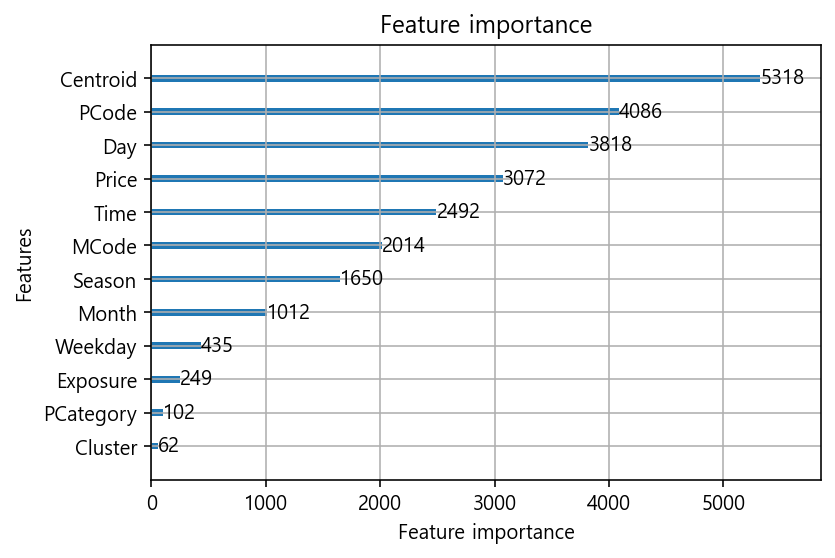

In [19]:
# 최적 파라미터일 때 feature importance
lgb.plot_importance(model)

In [39]:
# 예측 후 RMSE, MAPE 스코어 측정
def clip_pred(x):
    if x == 0:
        return 0.001
    else:
        return x

y_pred = model.predict(X_test)
result = test_data.copy()
result['AMT_pred'] = y_pred
result['AMT_pred'] = result['AMT_pred'].apply(lambda x: clip_pred(x)) # 예측값 클리핑
print('MAPE: ', mean_absolute_percentage_error(result['AMT'], result['AMT_pred']))
print('RMSE: ', mean_squared_error(result['AMT'], result['AMT_pred']) ** 0.5)

MAPE:  inf
RMSE:  14389530.88175388


## Feature 2

- `방송 일시`, `일_일련번호`, `상품명`, `클러스터` 제외 모든 컬럼 사용

In [48]:
# 컬럼 선택
df = data_raw[['Season', 'Month', 'Day', 'Weekday', 'Time', 'Exposure',\
               'PCategory', 'MCode', 'PCode', 'Price', 'Centroid', 'AMT']]

# 범주형 변수 인코딩
cat_features = ['Season', 'Weekday', 'PCategory', 'MCode', 'PCode']

encoders = {}
for column in cat_features:
    encoder = LabelEncoder()
    encoder.fit(df[column])
    encoders[column] = encoder

for column in encoders.keys():
    encoder = encoders[column]
    df[column] = encoder.transform(df[column])

display(df)
print(df.info())

# 계절 기준 계층적 샘플링
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in sss.split(df, df['Season']):
    train_data = df.loc[train_index]
    test_data = df.loc[test_index]

# 트레인 테스트 데이터 구성
X_train = train_data.iloc[:, :-1]
y_train = train_data.iloc[:, -1]
X_test = test_data.iloc[:, :-1]
y_test = test_data.iloc[:, -1]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# LGBM 데이터셋 구성
ds_train = lgb.Dataset(X_train, label=y_train, categorical_feature=[0, 1, 2, 3, 4, 6, 7, 8], free_raw_data=False)
ds_test = lgb.Dataset(X_test, label=y_test, categorical_feature=[0, 1, 2, 3, 4, 6, 7, 8], free_raw_data=False)

,Season,Month,Day,Weekday,Time,Exposure,PCategory,MCode,PCode,Price,Centroid,AMT
0,1,1,1,6,6,20.0,6,296,895,39900,-0.487678,2099000.0
1,1,1,1,6,6,20.0,6,296,902,39900,-0.487678,4371000.0
2,1,1,1,6,6,20.0,6,296,895,39900,-0.487678,3262000.0
...,...,...,...,...,...,...,...,...,...,...,...,...
37295,1,12,31,6,23,20.0,9,374,1133,168000,-0.019946,15282000.0
37296,1,12,31,6,23,20.0,9,374,1129,158000,-0.019946,2328000.0
37297,1,12,31,6,23,20.0,9,374,1134,148000,-0.019946,10157000.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37298 entries, 0 to 37297
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Season     37298 non-null  int32  
 1   Month      37298 non-null  int64  
 2   Day        37298 non-null  int64  
 3   Weekday    37298 non-null  int32  
 4   Time       37298 non-null  int64  
 5   Exposure   37298 non-null  float64
 6   PCategory  37298 non-null  int32  
 7   MCode      37298 non-null  int64  
 8   PCode      37298 non-null  int64  
 9   Price      37298 non-null  int64  
 10  Centroid   37298 non-null  float64
 11  AMT        37298 non-null  float64
dtypes: float64(3), int32(3), int64(6)
memory usage: 3.0 MB
None
(29838, 11) (29838,) (7460, 11) (7460,)


### 파라미터 변경 및 조합 기록

1. MAPE: 306489
```
params = {'learning_rate': 0.1, 
          'max_depth': -1, 
          'boosting': 'gbdt', 
          'objective': 'regression', 
          'metric': 'mape', 
          # 'num_leaves': 144, 
          'feature_fraction': 1, 
          'bagging_fraction': 0.8, 
          # 'bagging_freq': 5, 
          'seed':42,
          'cat_smooth':5}
```

2. MAPE: 297314
```
params = {'learning_rate': 0.1, 
          'max_depth': -1, 
          'boosting': 'gbdt', 
          'objective': 'regression', 
          'metric': 'mape', 
          'num_leaves': 144, 
          'feature_fraction': 0.7, 
          # 'bagging_fraction': 0.8, 
          # 'bagging_freq': 5, 
          'seed':42,
          'cat_smooth':5}
```

In [65]:
# 파라미터 구성
params = {'learning_rate': 0.1, 
          'max_depth': -1, 
          'boosting': 'gbdt', 
          'objective': 'regression', 
          'metric': 'mape', 
          'num_leaves': 144, 
          'feature_fraction': 0.7, 
          # 'bagging_fraction': 0.8, 
          # 'bagging_freq': 5, 
          'seed':42,
          'cat_smooth':5}

# 모델
model = lgb.train(params=params, 
                  train_set=ds_train,
                  num_boost_round=10000,
                  valid_sets=ds_test, 
                  verbose_eval=100, 
                  early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's mape: 298568
[200]	valid_0's mape: 302226
Early stopping, best iteration is:
[123]	valid_0's mape: 297314


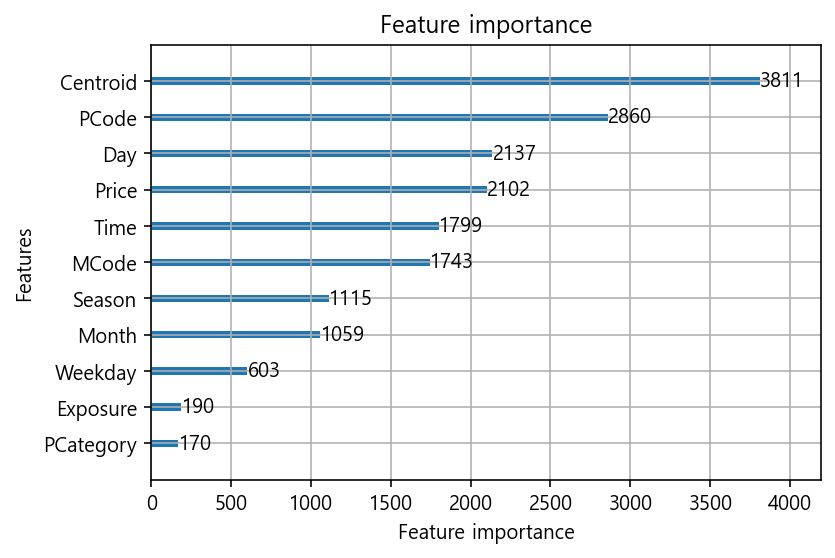

In [66]:
# 변수 중요도
lgb.plot_importance(model)

In [67]:
# 예측 후 RMSE, MAPE 스코어 측정
def clip_pred(x):
    if x == 0:
        return 0.001
    else:
        return x

y_pred = model.predict(X_test)
result = test_data.copy()
result['AMT_pred'] = y_pred
result['AMT_pred'] = result['AMT_pred'].apply(lambda x: clip_pred(x)) # 예측값 클리핑
print('MAPE: ', mean_absolute_percentage_error(result['AMT'], result['AMT_pred']))
print('RMSE: ', mean_squared_error(result['AMT'], result['AMT_pred']) ** 0.5)

MAPE:  inf
RMSE:  14278812.6920848


## Feature 3

- `방송 일시`, `일_일련번호`, `상품명`, `클러스터`, `상품군`, `노출` 제외 모든 컬럼 사용

In [69]:
# 컬럼 선택
df = data_raw[['Season', 'Month', 'Day', 'Weekday', 'Time', \
               'MCode', 'PCode', 'Price', 'Centroid', 'AMT']]

# 범주형 변수 인코딩
cat_features = ['Season', 'Weekday', 'MCode', 'PCode']

encoders = {}
for column in cat_features:
    encoder = LabelEncoder()
    encoder.fit(df[column])
    encoders[column] = encoder

for column in encoders.keys():
    encoder = encoders[column]
    df[column] = encoder.transform(df[column])

display(df)
print(df.info())

# 계절 기준 계층적 샘플링
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in sss.split(df, df['Season']):
    train_data = df.loc[train_index]
    test_data = df.loc[test_index]

# 트레인 테스트 데이터 구성
X_train = train_data.iloc[:, :-1]
y_train = train_data.iloc[:, -1]
X_test = test_data.iloc[:, :-1]
y_test = test_data.iloc[:, -1]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# LGBM 데이터셋 구성
ds_train = lgb.Dataset(X_train, label=y_train, categorical_feature=[0, 1, 2, 3, 5, 6], free_raw_data=False)
ds_test = lgb.Dataset(X_test, label=y_test, categorical_feature=[0, 1, 2, 3, 5, 6], free_raw_data=False)

,Season,Month,Day,Weekday,Time,MCode,PCode,Price,Centroid,AMT
0,1,1,1,6,6,296,895,39900,-0.487678,2099000.0
1,1,1,1,6,6,296,902,39900,-0.487678,4371000.0
2,1,1,1,6,6,296,895,39900,-0.487678,3262000.0
...,...,...,...,...,...,...,...,...,...,...
37295,1,12,31,6,23,374,1133,168000,-0.019946,15282000.0
37296,1,12,31,6,23,374,1129,158000,-0.019946,2328000.0
37297,1,12,31,6,23,374,1134,148000,-0.019946,10157000.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37298 entries, 0 to 37297
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Season    37298 non-null  int32  
 1   Month     37298 non-null  int64  
 2   Day       37298 non-null  int64  
 3   Weekday   37298 non-null  int32  
 4   Time      37298 non-null  int64  
 5   MCode     37298 non-null  int64  
 6   PCode     37298 non-null  int64  
 7   Price     37298 non-null  int64  
 8   Centroid  37298 non-null  float64
 9   AMT       37298 non-null  float64
dtypes: float64(2), int32(2), int64(6)
memory usage: 2.6 MB
None
(29838, 9) (29838,) (7460, 9) (7460,)


### 파라미터 변경 및 조합 기록 : 더 이상 의미가 없다.

In [75]:
# 파라미터 구성
params = {'learning_rate': 0.2, 
          'max_depth': 16, 
          'boosting': 'gbdt', 
          'objective': 'regression', 
          'metric': 'mape', 
          'num_leaves': 70, 
          'feature_fraction': 1, 
          'bagging_fraction': 0.8, 
          'bagging_freq': 5, 
          'seed':42,
          'cat_smooth':10}

# 모델
model = lgb.train(params=params, 
                  train_set=ds_train,
                  num_boost_round=10000,
                  valid_sets=ds_test, 
                  verbose_eval=100, 
                  early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's mape: 311538
Early stopping, best iteration is:
[44]	valid_0's mape: 305923


# 각 상품군에 대해서

## feature 선택 1

In [76]:
# 컬럼 선택
df = data_raw[['Season', 'Month', 'Day', 'Weekday', 'Time', 'Exposure',\
               'PCategory', 'MCode', 'PCode', 'Price', 'Cluster', 'Centroid', 'AMT']]
df.tail()

,Season,Month,Day,Weekday,Time,Exposure,PCategory,MCode,PCode,Price,Cluster,Centroid,AMT
37293,겨울,12,31,화요일,23,20.0,주방,100448,201391,148000,3,-0.019946,1664000.0
37294,겨울,12,31,화요일,23,20.0,주방,100448,201383,178000,3,-0.019946,9149000.0
37295,겨울,12,31,화요일,23,20.0,주방,100448,201390,168000,3,-0.019946,15282000.0
37296,겨울,12,31,화요일,23,20.0,주방,100448,201384,158000,3,-0.019946,2328000.0
37297,겨울,12,31,화요일,23,20.0,주방,100448,201391,148000,3,-0.019946,10157000.0


In [77]:
# 범주형 변수 인코딩
cat_features = ['Season', 'Weekday', 'PCategory', 'MCode', 'PCode']

encoders = {}
for column in cat_features:
    encoder = LabelEncoder()
    encoder.fit(df[column])
    encoders[column] = encoder

for column in encoders.keys():
    encoder = encoders[column]
    df[column] = encoder.transform(df[column])

display(df)
df.info()

,Season,Month,Day,Weekday,Time,Exposure,PCategory,MCode,PCode,Price,Cluster,Centroid,AMT
0,1,1,1,6,6,20.0,6,296,895,39900,4,-0.487678,2099000.0
1,1,1,1,6,6,20.0,6,296,902,39900,4,-0.487678,4371000.0
2,1,1,1,6,6,20.0,6,296,895,39900,4,-0.487678,3262000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
37295,1,12,31,6,23,20.0,9,374,1133,168000,3,-0.019946,15282000.0
37296,1,12,31,6,23,20.0,9,374,1129,158000,3,-0.019946,2328000.0
37297,1,12,31,6,23,20.0,9,374,1134,148000,3,-0.019946,10157000.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37298 entries, 0 to 37297
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Season     37298 non-null  int32  
 1   Month      37298 non-null  int64  
 2   Day        37298 non-null  int64  
 3   Weekday    37298 non-null  int32  
 4   Time       37298 non-null  int64  
 5   Exposure   37298 non-null  float64
 6   PCategory  37298 non-null  int32  
 7   MCode      37298 non-null  int64  
 8   PCode      37298 non-null  int64  
 9   Price      37298 non-null  int64  
 10  Cluster    37298 non-null  int64  
 11  Centroid   37298 non-null  float64
 12  AMT        37298 non-null  float64
dtypes: float64(3), int32(3), int64(7)
memory usage: 3.3 MB


### 파라미터 구성 변경

================== 가구 ==================
(2089, 11) (2089,) (523, 11) (523,)
Training until validation scores don't improve for 100 rounds
[100]	valid_0's mape: 429147
[200]	valid_0's mape: 472179
Early stopping, best iteration is:
[100]	valid_0's mape: 429147


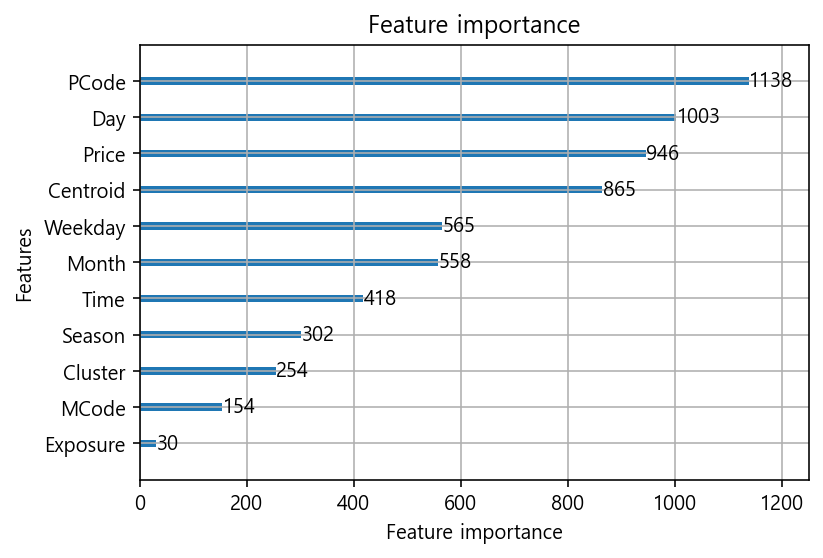

MAPE:  inf
RMSE:  9510236.842443867

================== 가전 ==================
(5183, 11) (5183,) (1296, 11) (1296,)
Training until validation scores don't improve for 100 rounds
[100]	valid_0's mape: 1.25633e+06
Early stopping, best iteration is:
[87]	valid_0's mape: 1.23869e+06


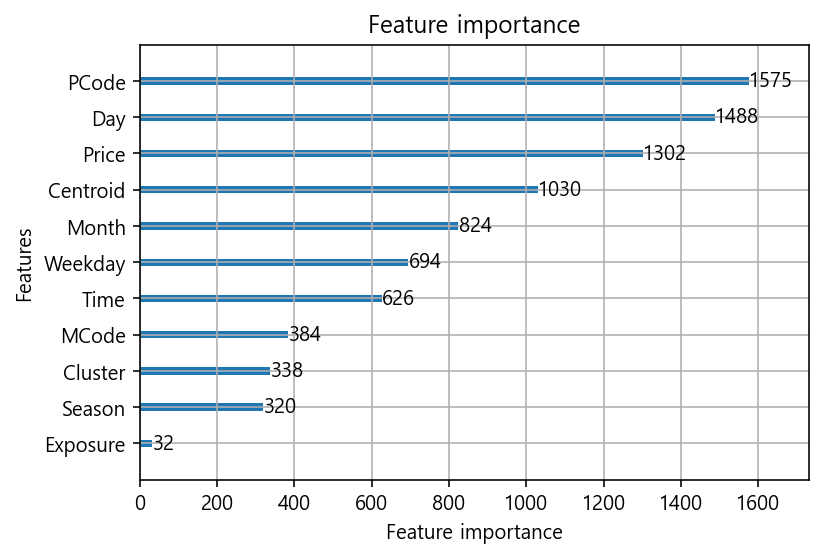

MAPE:  inf
RMSE:  13186356.899080714

================== 건강기능 ==================
(628, 11) (628,) (157, 11) (157,)
Training until validation scores don't improve for 100 rounds
[100]	valid_0's mape: 117406
[200]	valid_0's mape: 109215
[300]	valid_0's mape: 89699.8
[400]	valid_0's mape: 67705.3
Early stopping, best iteration is:
[371]	valid_0's mape: 59587.8


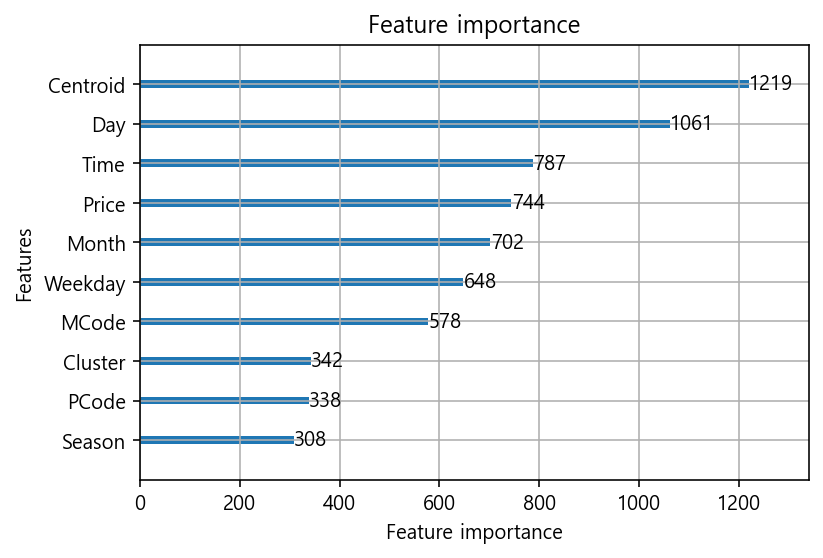

MAPE:  inf
RMSE:  13011408.60492688

================== 농수축 ==================
(3104, 11) (3104,) (776, 11) (776,)
Training until validation scores don't improve for 100 rounds
[100]	valid_0's mape: 0.377119
Early stopping, best iteration is:
[45]	valid_0's mape: 0.357234


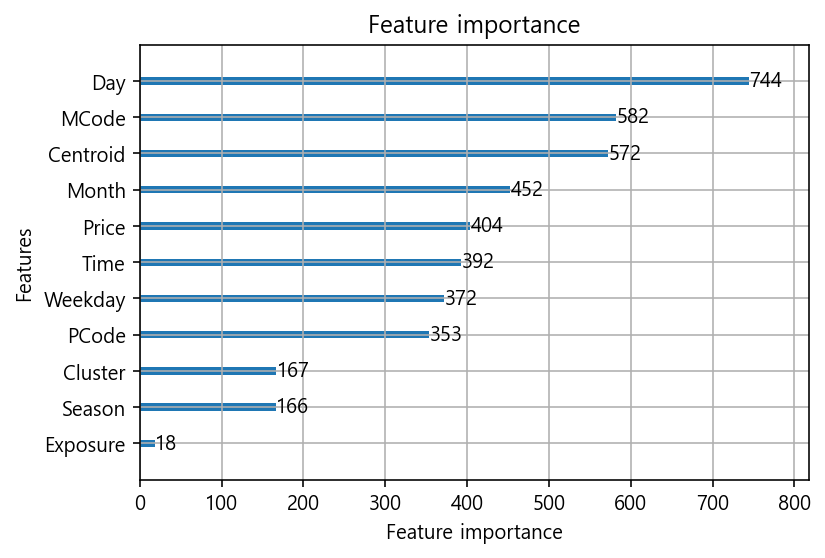

MAPE:  35.72335863499212
RMSE:  17744187.410075456

================== 생활용품 ==================
(2289, 11) (2289,) (573, 11) (573,)
Training until validation scores don't improve for 100 rounds
[100]	valid_0's mape: 115885
[200]	valid_0's mape: 112287
Early stopping, best iteration is:
[132]	valid_0's mape: 107341


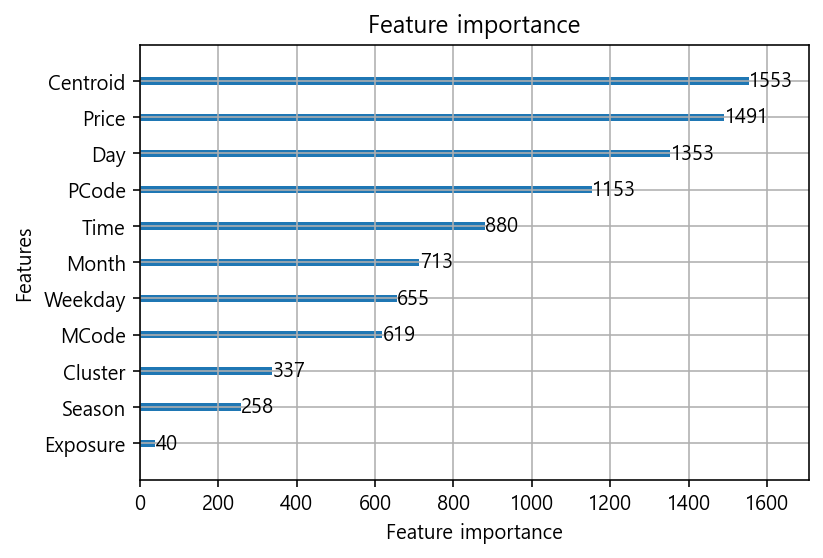

MAPE:  inf
RMSE:  12167083.93449943

================== 속옷 ==================
(3127, 11) (3127,) (782, 11) (782,)
Training until validation scores don't improve for 100 rounds
[100]	valid_0's mape: 16658
[200]	valid_0's mape: 16389.8
Early stopping, best iteration is:
[110]	valid_0's mape: 15198.5


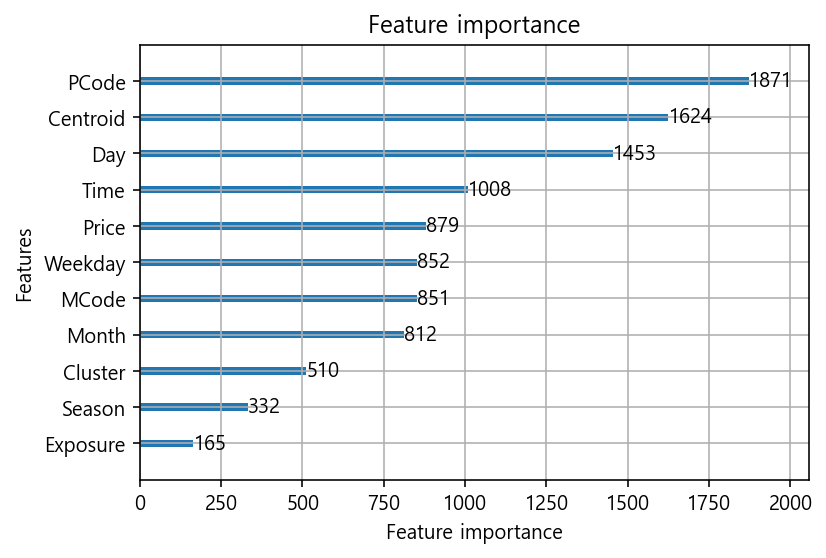

MAPE:  inf
RMSE:  15736000.234562812

================== 의류 ==================
(3464, 11) (3464,) (867, 11) (867,)
Training until validation scores don't improve for 100 rounds
[100]	valid_0's mape: 0.618478
Early stopping, best iteration is:
[72]	valid_0's mape: 0.609075


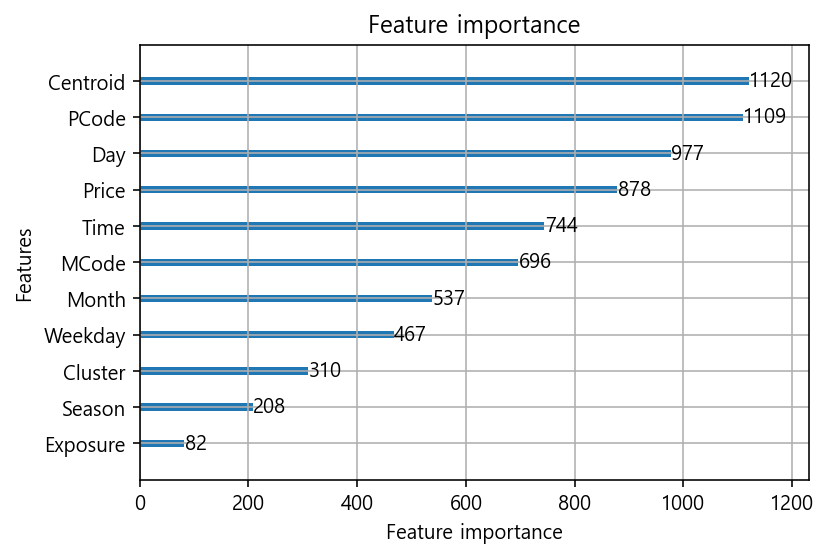

MAPE:  60.90748769417774
RMSE:  16232907.280002326

================== 이미용 ==================
(1036, 11) (1036,) (259, 11) (259,)
Training until validation scores don't improve for 100 rounds
[100]	valid_0's mape: 0.512705
[200]	valid_0's mape: 0.514801
Early stopping, best iteration is:
[139]	valid_0's mape: 0.503559


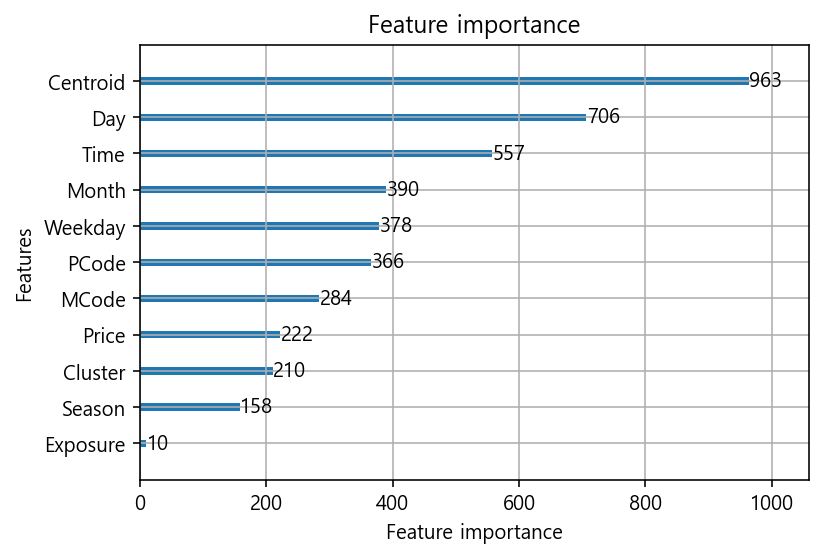

MAPE:  50.355869162801966
RMSE:  18883092.443747774

================== 잡화 ==================
(3106, 11) (3106,) (777, 11) (777,)
Training until validation scores don't improve for 100 rounds
[100]	valid_0's mape: 459495
Early stopping, best iteration is:
[21]	valid_0's mape: 405848


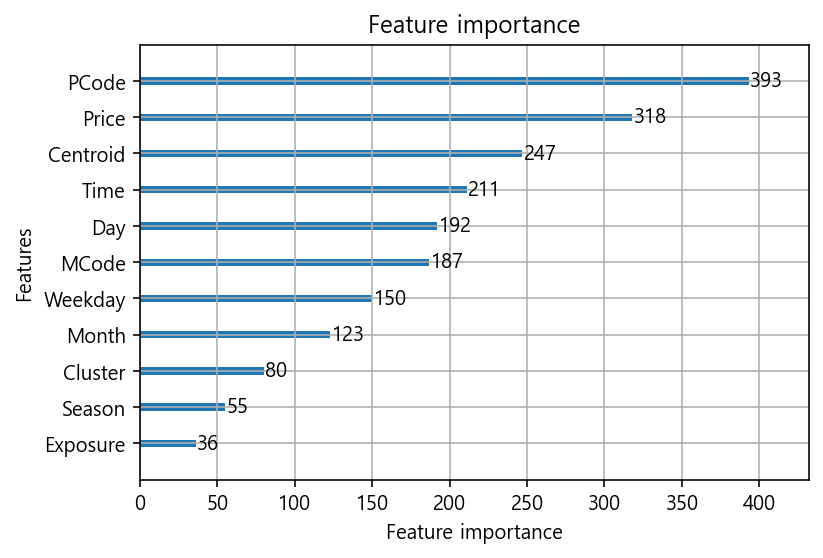

MAPE:  inf
RMSE:  10196721.32175617

================== 주방 ==================
(5277, 11) (5277,) (1320, 11) (1320,)
Training until validation scores don't improve for 100 rounds
[100]	valid_0's mape: 17560.3
Early stopping, best iteration is:
[75]	valid_0's mape: 15963.4


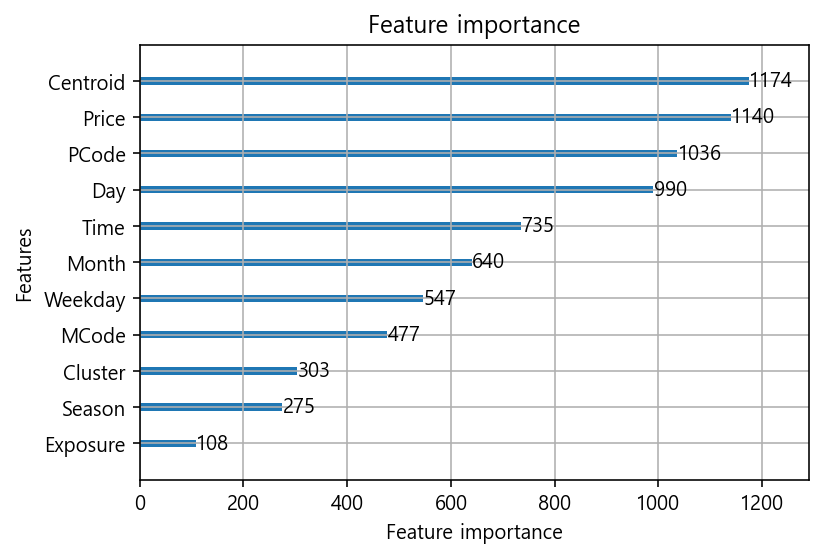

MAPE:  inf
RMSE:  14760050.950636217

================== 침구 ==================
(532, 11) (532,) (133, 11) (133,)
Training until validation scores don't improve for 100 rounds
[100]	valid_0's mape: 12322.4
[200]	valid_0's mape: 8345.85
[300]	valid_0's mape: 7300.81
Early stopping, best iteration is:
[280]	valid_0's mape: 4865.86


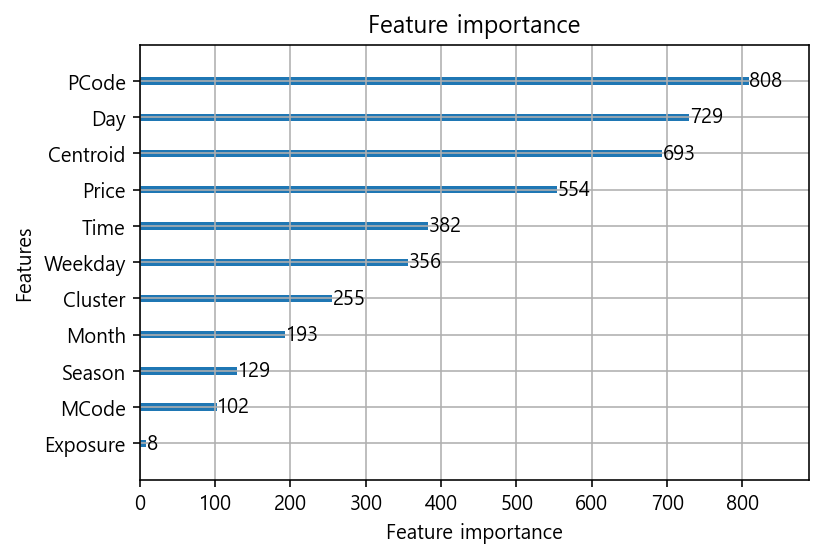

MAPE:  inf
RMSE:  6835059.62135825



In [92]:
for kind in range(11):
    print(f"================== {encoders['PCategory'].classes_[kind]} ==================")
    kind_df = df[df['PCategory'] == kind].copy()
    kind_df = kind_df.drop('PCategory', axis=1) # 상품군 컬럼 사용하지 않음.
    kind_df = kind_df.reset_index(drop=True) # 인덱스 정렬
    
    # 계절 기준 계층적 샘플링
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_index, test_index in sss.split(kind_df, kind_df['Season']):
        train_data = kind_df.loc[train_index]
        test_data = kind_df.loc[test_index]
        
    # 트레인 테스트 데이터 구성
    X_train = train_data.iloc[:, :-1]
    y_train = train_data.iloc[:, -1]
    X_test = test_data.iloc[:, :-1]
    y_test = test_data.iloc[:, -1]
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    
    # LGBM 데이터셋 구성
#     ds_train = lgb.Dataset(X_train, label=y_train, categorical_feature=[0, 1, 2, 3, 4, 6, 7, 9], free_raw_data=False)
#     ds_test = lgb.Dataset(X_test, label=y_test, categorical_feature=[0, 1, 2, 3, 4, 6, 7, 9], free_raw_data=False)
    ds_train = lgb.Dataset(X_train, label=y_train, free_raw_data=False)
    ds_test = lgb.Dataset(X_test, label=y_test, free_raw_data=False)
    
    # 파라미터 구성
    params = {'learning_rate': 0.15, 
              'max_depth': -1, 
              'boosting': 'gbdt', 
              'objective': 'regression', 
              'metric': 'mape', 
              'num_leaves': 100, 
              'feature_fraction': 0.9, 
              'bagging_fraction': 0.8, 
              'bagging_freq': 10, 
              'seed':42}
              # 'cat_smooth':5}
    
    # 모델
    model = lgb.train(params=params, 
                      train_set=ds_train,
                      num_boost_round=10000,
                      valid_sets=ds_test, 
                      verbose_eval=100, 
                      early_stopping_rounds=100)
    
    # 변수 중요도
    lgb.plot_importance(model)
    plt.show()
    
    # 예측 후 MAPE, RMSE 스코어 측정
    y_pred = model.predict(X_test)
    result = test_data.copy()
    result['AMT_pred'] = y_pred
    # result['AMT_pred'] = result['AMT_pred'].apply(lambda x: clip_pred(x)) # 예측값 클리핑
    print('MAPE: ', mean_absolute_percentage_error(result['AMT'], result['AMT_pred']))
    print('RMSE: ', mean_squared_error(result['AMT'], result['AMT_pred']) ** 0.5)
    print()

## feature 선택 2
- cluster`, `exposure` 제외

In [93]:
# 컬럼 선택
df = data_raw[['Season', 'Month', 'Day', 'Weekday', 'Time',\
               'PCategory', 'MCode', 'PCode', 'Price', 'Centroid', 'AMT']]

# 범주형 변수 인코딩
cat_features = ['Season', 'Weekday', 'PCategory', 'MCode', 'PCode']

encoders = {}
for column in cat_features:
    encoder = LabelEncoder()
    encoder.fit(df[column])
    encoders[column] = encoder

for column in encoders.keys():
    encoder = encoders[column]
    df[column] = encoder.transform(df[column])

display(df)
df.info()

,Season,Month,Day,Weekday,Time,PCategory,MCode,PCode,Price,Centroid,AMT
0,1,1,1,6,6,6,296,895,39900,-0.487678,2099000.0
1,1,1,1,6,6,6,296,902,39900,-0.487678,4371000.0
2,1,1,1,6,6,6,296,895,39900,-0.487678,3262000.0
...,...,...,...,...,...,...,...,...,...,...,...
37295,1,12,31,6,23,9,374,1133,168000,-0.019946,15282000.0
37296,1,12,31,6,23,9,374,1129,158000,-0.019946,2328000.0
37297,1,12,31,6,23,9,374,1134,148000,-0.019946,10157000.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37298 entries, 0 to 37297
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Season     37298 non-null  int32  
 1   Month      37298 non-null  int64  
 2   Day        37298 non-null  int64  
 3   Weekday    37298 non-null  int32  
 4   Time       37298 non-null  int64  
 5   PCategory  37298 non-null  int32  
 6   MCode      37298 non-null  int64  
 7   PCode      37298 non-null  int64  
 8   Price      37298 non-null  int64  
 9   Centroid   37298 non-null  float64
 10  AMT        37298 non-null  float64
dtypes: float64(2), int32(3), int64(6)
memory usage: 2.7 MB


================== 가구 ==================
(2089, 9) (2089,) (523, 9) (523,)
Training until validation scores don't improve for 100 rounds
[50]	valid_0's mape: 466629
[100]	valid_0's mape: 433574
[150]	valid_0's mape: 437561
[200]	valid_0's mape: 445386
Early stopping, best iteration is:
[141]	valid_0's mape: 431714


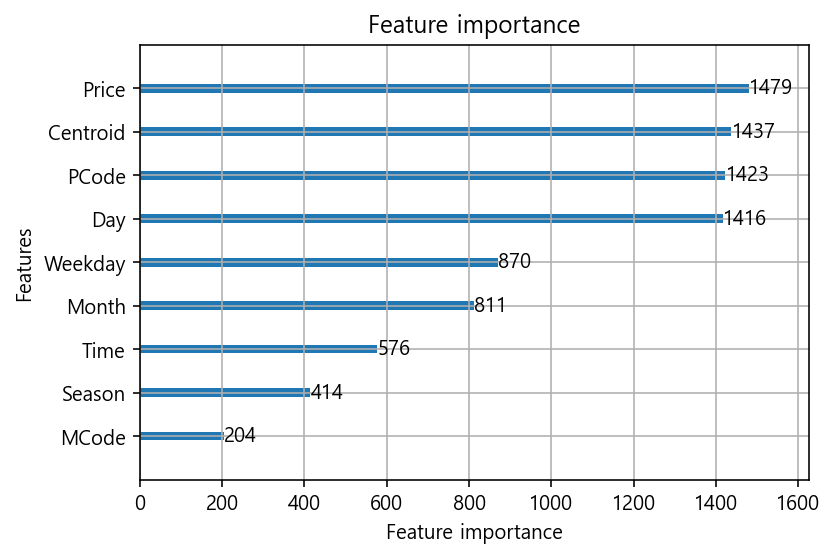

MAPE:  inf
RMSE:  9423197.361548128

================== 가전 ==================
(5183, 9) (5183,) (1296, 9) (1296,)
Training until validation scores don't improve for 100 rounds
[50]	valid_0's mape: 1.27534e+06
[100]	valid_0's mape: 1.24405e+06
[150]	valid_0's mape: 1.23573e+06
[200]	valid_0's mape: 1.22136e+06
[250]	valid_0's mape: 1.25339e+06
Early stopping, best iteration is:
[180]	valid_0's mape: 1.22066e+06


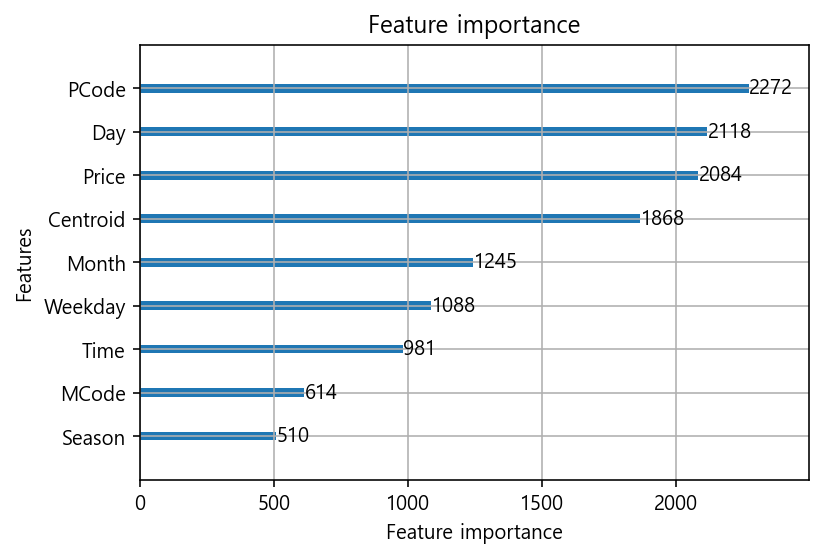

MAPE:  inf
RMSE:  13217909.027168019

================== 건강기능 ==================
(628, 9) (628,) (157, 9) (157,)
Training until validation scores don't improve for 100 rounds
[50]	valid_0's mape: 137743
[100]	valid_0's mape: 124602
[150]	valid_0's mape: 113165
[200]	valid_0's mape: 106509
[250]	valid_0's mape: 91436.5
[300]	valid_0's mape: 99665.1
[350]	valid_0's mape: 89078.3
[400]	valid_0's mape: 88738.9
[450]	valid_0's mape: 90756.5
[500]	valid_0's mape: 88788.3
[550]	valid_0's mape: 87204
[600]	valid_0's mape: 76869.6
[650]	valid_0's mape: 79118
[700]	valid_0's mape: 91036
Early stopping, best iteration is:
[616]	valid_0's mape: 76056.6


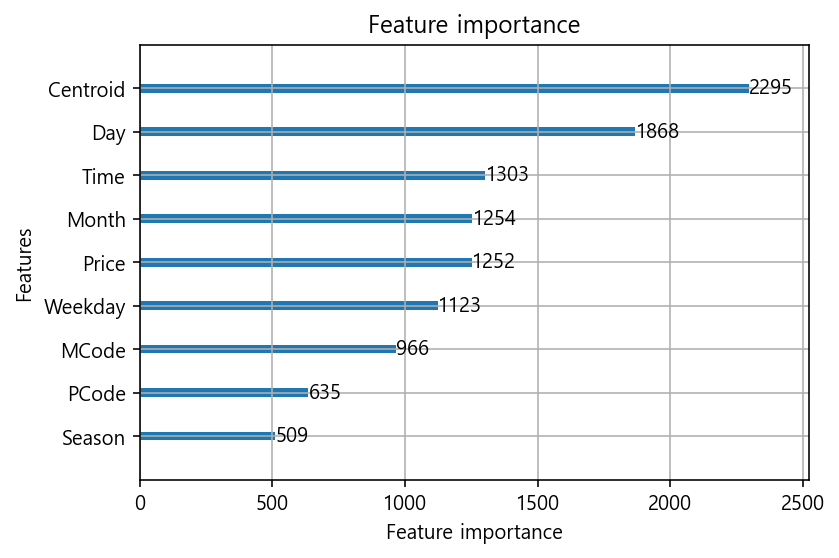

MAPE:  inf
RMSE:  13100903.58775673

================== 농수축 ==================
(3104, 9) (3104,) (776, 9) (776,)
Training until validation scores don't improve for 100 rounds
[50]	valid_0's mape: 0.353008
[100]	valid_0's mape: 0.35667
[150]	valid_0's mape: 0.366129
Early stopping, best iteration is:
[70]	valid_0's mape: 0.34601


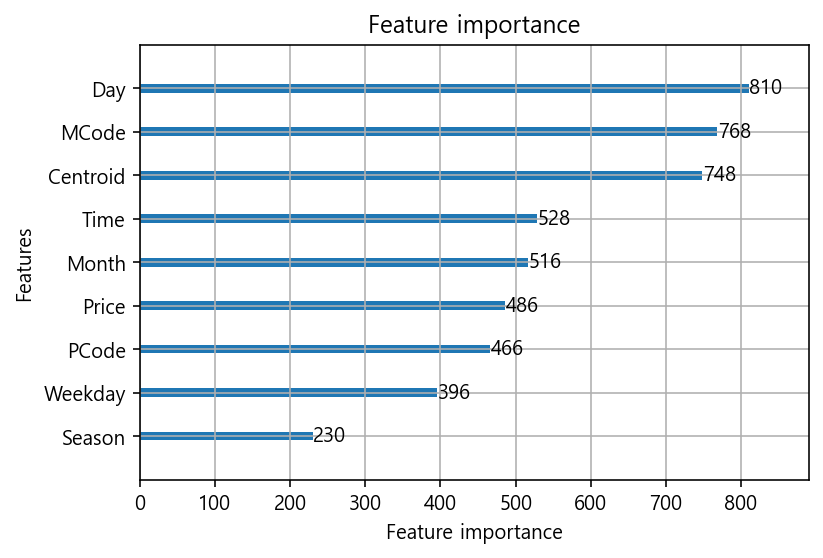

MAPE:  34.60097489378939
RMSE:  17660586.973106083

================== 생활용품 ==================
(2289, 9) (2289,) (573, 9) (573,)
Training until validation scores don't improve for 100 rounds
[50]	valid_0's mape: 113219
[100]	valid_0's mape: 96316.2
[150]	valid_0's mape: 98381.4
[200]	valid_0's mape: 93541.1
[250]	valid_0's mape: 102185
[300]	valid_0's mape: 86625.1
[350]	valid_0's mape: 100778
Early stopping, best iteration is:
[294]	valid_0's mape: 86536.2


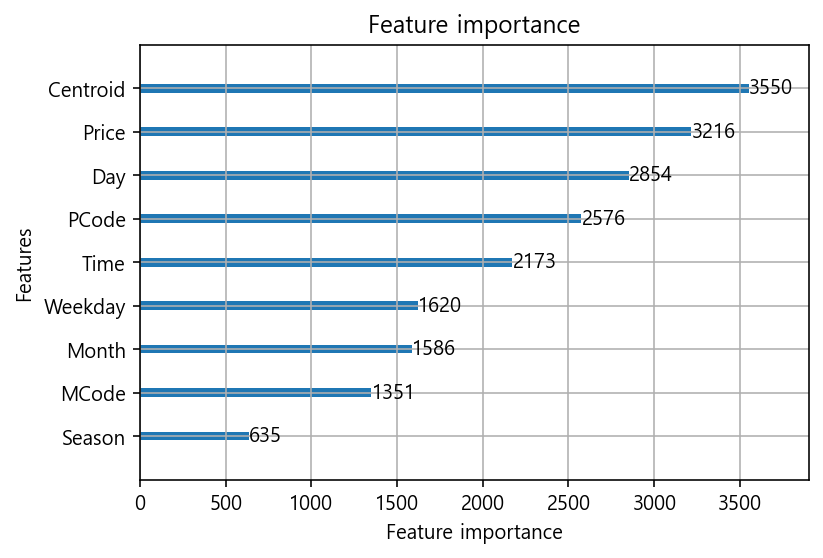

MAPE:  inf
RMSE:  12476905.041724695

================== 속옷 ==================
(3127, 9) (3127,) (782, 9) (782,)
Training until validation scores don't improve for 100 rounds
[50]	valid_0's mape: 22201.5
[100]	valid_0's mape: 20192.7
[150]	valid_0's mape: 20018.9
[200]	valid_0's mape: 19510.4
[250]	valid_0's mape: 18965.2
[300]	valid_0's mape: 18847.9
Early stopping, best iteration is:
[238]	valid_0's mape: 17614.1


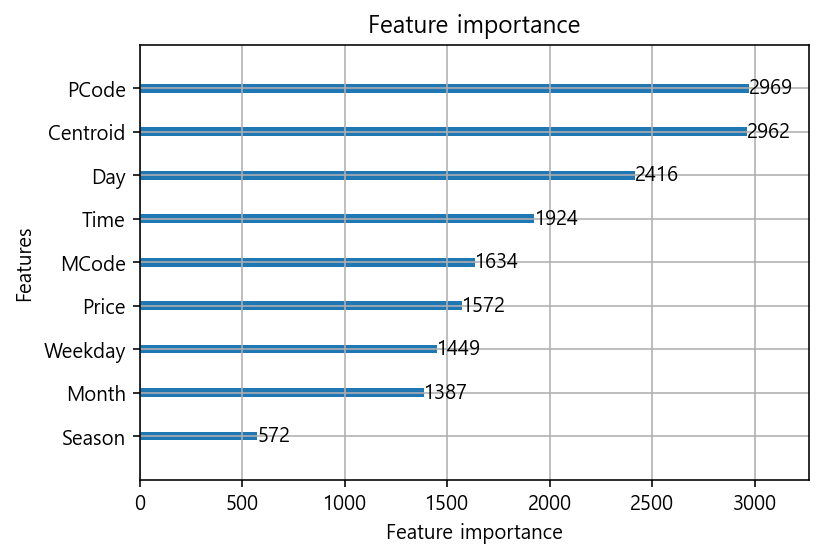

MAPE:  inf
RMSE:  16114916.636422047

================== 의류 ==================
(3464, 9) (3464,) (867, 9) (867,)
Training until validation scores don't improve for 100 rounds
[50]	valid_0's mape: 0.645934
[100]	valid_0's mape: 0.616484
[150]	valid_0's mape: 0.603157
[200]	valid_0's mape: 0.613853
[250]	valid_0's mape: 0.608937
Early stopping, best iteration is:
[181]	valid_0's mape: 0.600907


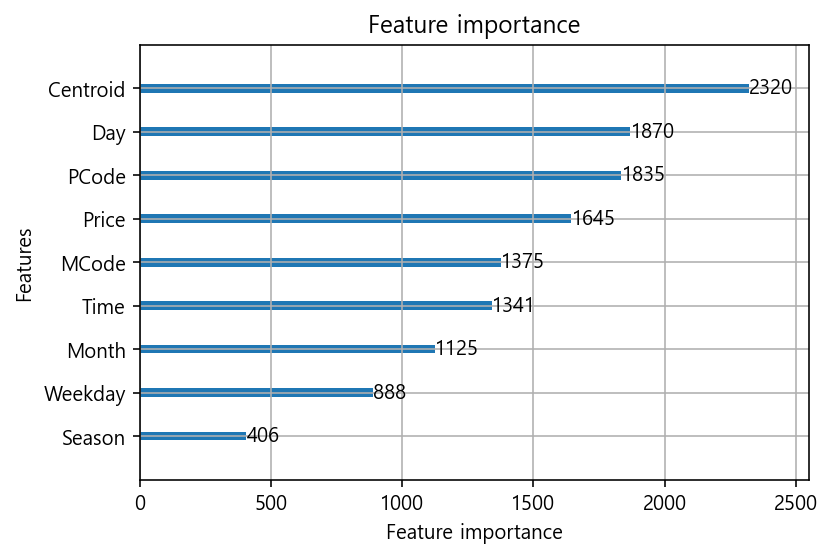

MAPE:  60.090730121423555
RMSE:  16729485.858988453

================== 이미용 ==================
(1036, 9) (1036,) (259, 9) (259,)
Training until validation scores don't improve for 100 rounds
[50]	valid_0's mape: 0.477385
[100]	valid_0's mape: 0.463161
[150]	valid_0's mape: 0.467088
[200]	valid_0's mape: 0.470155
Early stopping, best iteration is:
[140]	valid_0's mape: 0.459305


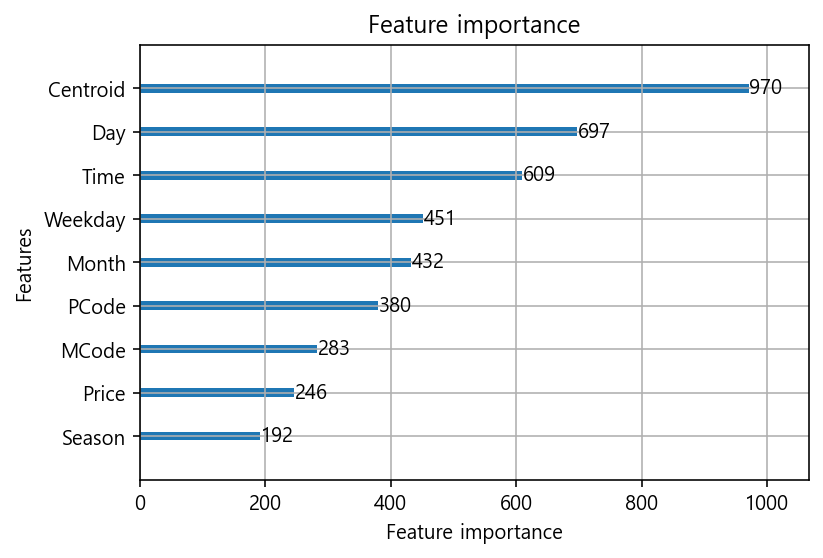

MAPE:  45.930487066375306
RMSE:  18510703.668975715

================== 잡화 ==================
(3106, 9) (3106,) (777, 9) (777,)
Training until validation scores don't improve for 100 rounds
[50]	valid_0's mape: 436803
[100]	valid_0's mape: 440622
[150]	valid_0's mape: 444784
Early stopping, best iteration is:
[90]	valid_0's mape: 411308


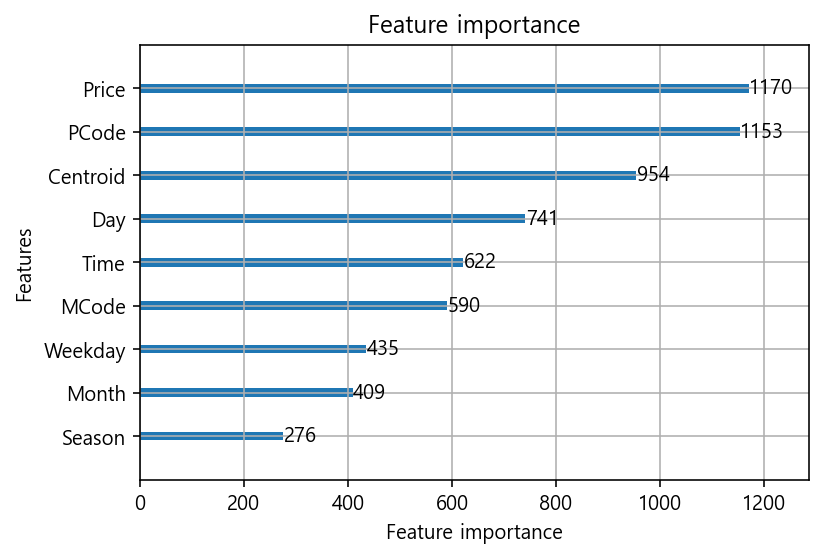

MAPE:  inf
RMSE:  10588885.493240349

================== 주방 ==================
(5277, 9) (5277,) (1320, 9) (1320,)
Training until validation scores don't improve for 100 rounds
[50]	valid_0's mape: 18253.4
[100]	valid_0's mape: 17235.7
[150]	valid_0's mape: 17287.9
[200]	valid_0's mape: 15996.3
[250]	valid_0's mape: 14546.8
[300]	valid_0's mape: 10950.7
[350]	valid_0's mape: 11908.1
[400]	valid_0's mape: 12062.7
Early stopping, best iteration is:
[310]	valid_0's mape: 10745.5


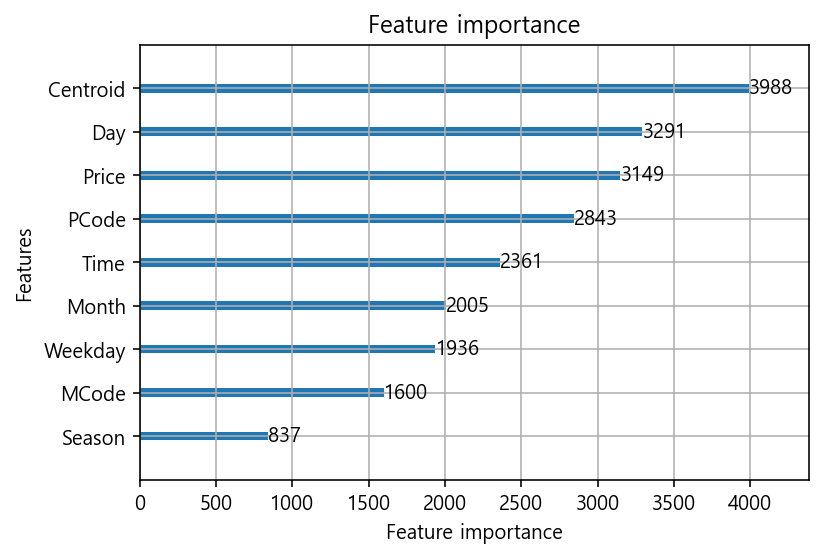

MAPE:  inf
RMSE:  15153948.824778102

================== 침구 ==================
(532, 9) (532,) (133, 9) (133,)
Training until validation scores don't improve for 100 rounds
[50]	valid_0's mape: 18931.4
[100]	valid_0's mape: 13124.1
[150]	valid_0's mape: 13908.8
Early stopping, best iteration is:
[76]	valid_0's mape: 9313.73


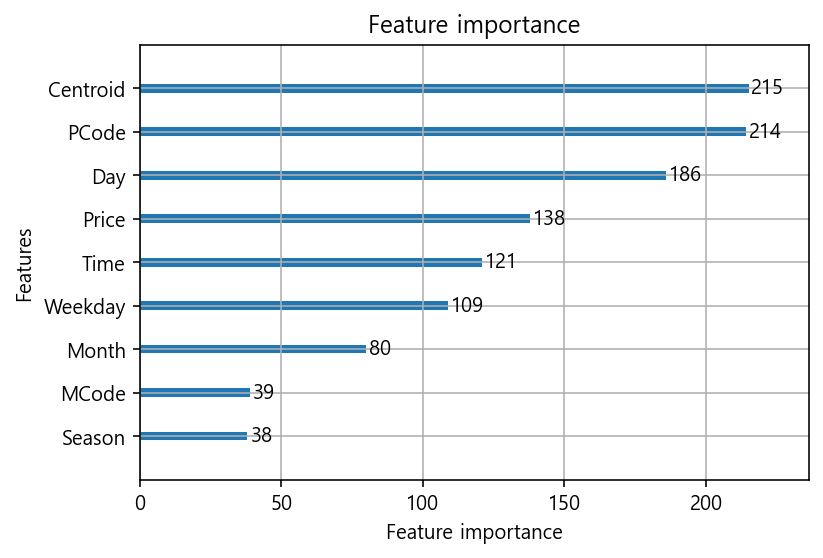

MAPE:  inf
RMSE:  5770433.604184189



In [95]:
for kind in range(11):
    print(f"================== {encoders['PCategory'].classes_[kind]} ==================")
    kind_df = df[df['PCategory'] == kind].copy()
    kind_df = kind_df.drop('PCategory', axis=1) # 상품군 컬럼 사용하지 않음.
    kind_df = kind_df.reset_index(drop=True) # 인덱스 정렬
    
    # 계절 기준 계층적 샘플링
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_index, test_index in sss.split(kind_df, kind_df['Season']):
        train_data = kind_df.loc[train_index]
        test_data = kind_df.loc[test_index]
        
    # 트레인 테스트 데이터 구성
    X_train = train_data.iloc[:, :-1]
    y_train = train_data.iloc[:, -1]
    X_test = test_data.iloc[:, :-1]
    y_test = test_data.iloc[:, -1]
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    
    # LGBM 데이터셋 구성
    ds_train = lgb.Dataset(X_train, label=y_train, free_raw_data=False)
    ds_test = lgb.Dataset(X_test, label=y_test, free_raw_data=False)
    
    # 파라미터 구성
    params = {'learning_rate': 0.1, 
              'max_depth': 16, 
              'boosting': 'gbdt', 
              'objective': 'regression', 
              'metric': 'mape', 
              'num_leaves': 72, 
              'feature_fraction': 0.9, 
              'bagging_fraction': 0.8, 
              'bagging_freq': 10, 
              'seed':42}
              # 'cat_smooth':5}
    
    # 모델
    model = lgb.train(params=params, 
                      train_set=ds_train,
                      num_boost_round=10000,
                      valid_sets=ds_test, 
                      verbose_eval=50, 
                      early_stopping_rounds=100)
    
    # 변수 중요도
    lgb.plot_importance(model)
    plt.show()
    
    # 예측 후 MAPE, RMSE 스코어 측정
    y_pred = model.predict(X_test)
    result = test_data.copy()
    result['AMT_pred'] = y_pred
    # result['AMT_pred'] = result['AMT_pred'].apply(lambda x: clip_pred(x)) # 예측값 클리핑
    print('MAPE: ', mean_absolute_percentage_error(result['AMT'], result['AMT_pred']))
    print('RMSE: ', mean_squared_error(result['AMT'], result['AMT_pred']) ** 0.5)
    print()